# Recognition Parametrized Model (RPM): Peer Supervision


Observations $\mathcal{X} = \{ x_j \}$ are groups of MNIST images representing $J$ different renderings of the same digit. The RPM to extract this information without explicit label information - a setting that might be termed "peer-supervision". The model writes:

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{j} \left( \mathsf{p_{0,j}}(\mathsf{x_{j}}) \frac{\mathsf{f_{\theta j}}(\mathsf{\mathcal{Z}} | \mathsf{x_{j}})}{\mathsf{F_{\theta j}}(\mathcal{Z})} \right) $$

## Load and Rearanged MNIST

In [2]:
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from utils_process import plot_loss

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils_demo import rearrange_mnist

from fast_rpm import RPM
import torch.nn.functional as F


data_folder = './../MNIST'

# Load MNIST
train_data = datasets.MNIST(
    root=data_folder,
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root=data_folder,
    train=False,
    transform=ToTensor()
)

# Random seeds
torch.manual_seed(10)

# Number of Conditionally independent Factors
num_factors = 2

# Sub-Sample original dataset
train_length = 60000

# Keep Only some digits (for efficiency)
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
sub_ids = torch.tensor([0, 1])
num_digits = len(sub_ids)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations, train_images, train_labels = rearrange_mnist(
    train_data.train_data, 
    train_data.train_labels, 
    num_factors, 
    train_length=train_length,
    sub_ids=sub_ids
)


# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations_test, test_images, test_labels = rearrange_mnist(
    test_data.test_data, 
    test_data.test_labels, 
    num_factors, 
    train_length=test_data.test_labels.shape[0],
    sub_ids=sub_ids
)
test_labels = test_labels.reshape(observations_test[0].shape[0], num_factors)
            


## Typical Observations

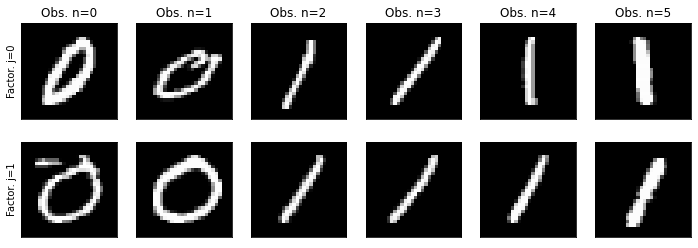

In [3]:
num_plot = np.arange(6)
plt.figure(figsize=(len(num_plot)*2, num_factors*2))
for obsi in range(len(num_plot)):
    for facti in range(num_factors):
        plt.subplot(num_factors, len(num_plot), (1+obsi) + facti * len(num_plot))
        plt.imshow(observations[facti][num_plot[obsi], :, :], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if facti == 0:
            plt.title('Obs. n=' + str(obsi))
        if obsi == 0:
            plt.ylabel('Factor. j=' + str(facti))

## Fit

In [4]:
# GPUs ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data type: float64 / float32
data_type = torch.float32
torch.set_default_dtype(data_type)

# Training Move to GPU
obs = [(obsi / obsi.max()).to(device) for obsi in observations]

# Testing Move to GPU
obs_test = [(obsi / obsi.max()).to(device) for obsi in observations_test]

In [5]:
obs[1] += 3 * torch.rand(obs[1].shape, device=device)
obs_test[1] += 3 * torch.rand(obs_test[1].shape, device=device)


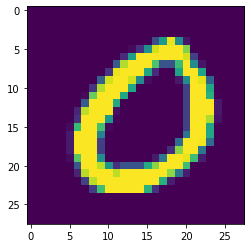

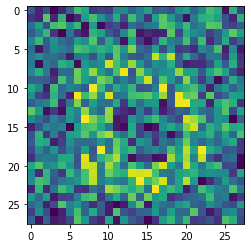

In [6]:
nn = 90
oplot = obs 

plt.figure()
plt.imshow(oplot[0][nn].to("cpu"))

plt.figure()
plt.imshow(oplot[1][nn].to("cpu"))

Text(0.5, 0, 'Epoch')

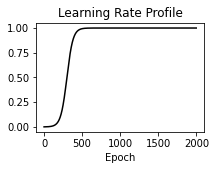

In [7]:

num_epoch = 2000
alpha =  40
beta = 300

lr_sigmoid = lambda xx: np.exp(- 1 / ((xx + 1) * alpha) ** 2)


lr_sigmoid = lambda xx: np.exp(xx) / (1 + np.exp(xx))
lr_sigmoid1 = lambda xx: lr_sigmoid((xx-beta)/alpha) - lr_sigmoid((0-beta)/alpha) 
lr_sigmoidf = lambda xx: lr_sigmoid1(xx) / lr_sigmoid1(num_epoch)
 



xx = np.arange(num_epoch)
yy = lr_sigmoidf(xx)

plt.figure(figsize=(3, 2))
plt.plot(xx, yy, c='k')
plt.title('Learning Rate Profile')
plt.xlabel('Epoch')

In [19]:
# Fit params

factors_params = {
    'channels': [[1, 10, 20], [1, 10, 20]],
    'kernel_conv': [[5, 5], [5, 5]],
    'kernel_pool': [[2, 2], [2, 2]],
    'dim_hidden': [[50], [50]],
    'nonlinearity': [F.relu, F.relu],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-4),
    #'scheduler': lambda optim: torch.optim.lr_scheduler.LambdaLR(optim, lr_sigmoid),
}

fit_params = {
    'num_epoch': 712,
    'batch_size': 2000,
    'dim_latent': 2,
    'factors_params': factors_params,
    'pct': 0.01
}

rpm = RPM(
    observations=obs,
    fit_params=fit_params,
)


RPM on GPU Observations on cuda:0


In [20]:
rpm.precision_chol_vec_factors

tensor([[-0.4509,  0.9406,  0.2494],
        [-0.1463, -0.7950,  1.0223]], device='cuda:0', requires_grad=True)

In [21]:
rpm.precision_chol_vec_auxiliary

tensor([[-0.4572, -1.0607,  0.4567],
        [-1.3313, -0.1225, -0.6685]], device='cuda:0', requires_grad=True)

In [22]:
with torch.no_grad():
    tmp = rpm._get_loss()
tmp.dtype

torch.float32

In [23]:
rpm.fit(obs)

Epoch 7/712 Loss: 1.645279e+01
Epoch 14/712 Loss: 1.644033e+01
Epoch 21/712 Loss: 1.642882e+01
Epoch 28/712 Loss: 1.641750e+01
Epoch 35/712 Loss: 1.640625e+01
Epoch 42/712 Loss: 1.639503e+01
Epoch 49/712 Loss: 1.638388e+01
Epoch 56/712 Loss: 1.637280e+01
Epoch 63/712 Loss: 1.636177e+01
Epoch 70/712 Loss: 1.635080e+01
Epoch 77/712 Loss: 1.633985e+01
Epoch 84/712 Loss: 1.632887e+01
Epoch 91/712 Loss: 1.631792e+01
Epoch 98/712 Loss: 1.630699e+01
Epoch 105/712 Loss: 1.629606e+01
Epoch 112/712 Loss: 1.628510e+01
Epoch 119/712 Loss: 1.627420e+01
Epoch 126/712 Loss: 1.626325e+01
Epoch 133/712 Loss: 1.625228e+01
Epoch 140/712 Loss: 1.624129e+01
Epoch 147/712 Loss: 1.623028e+01
Epoch 154/712 Loss: 1.621923e+01
Epoch 161/712 Loss: 1.620813e+01
Epoch 168/712 Loss: 1.619691e+01
Epoch 175/712 Loss: 1.618546e+01
Epoch 182/712 Loss: 1.617380e+01
Epoch 189/712 Loss: 1.616142e+01
Epoch 196/712 Loss: 1.614783e+01
Epoch 203/712 Loss: 1.613341e+01
Epoch 210/712 Loss: 1.611909e+01
Epoch 217/712 Loss: 1.610

In [18]:
print(rpm.precision_chol_vec_factors)
print(rpm.precision_chol_vec_auxiliary)


with torch.no_grad():
    rpm._forward_all(obs)
    tmp = rpm._get_loss()
    
    rpm.epoch = 709
    batches = self.batches[epoch]

    # Current epoch losses
    loss_batch = []

    


tensor([[nan, nan, nan],
        [nan, nan, nan]], device='cuda:0', requires_grad=True)
tensor([[nan, nan, nan],
        [nan, nan, nan]], device='cuda:0', requires_grad=True)


NameError: name 'self' is not defined

tensor(4.7356, device='cuda:0', dtype=torch.float64)

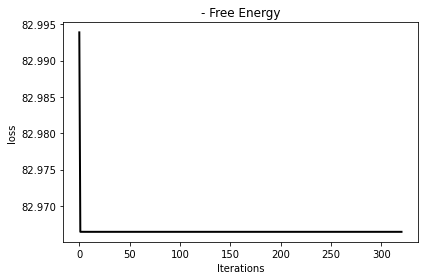

In [12]:
plot_loss(rpm, offset=0)

#plt.plot(rpm.loss_tot[:10])

## Latent Distribution Embeddings of test images

In [389]:
rpm.forwarded_factors[1]


tensor([[[-3.0033, -2.6733],
         [-2.6733, -3.8579]],

        [[-0.5417, -0.0753],
         [-0.0753, -0.7999]]], device='cuda:0', grad_fn=<SubBackward0>)

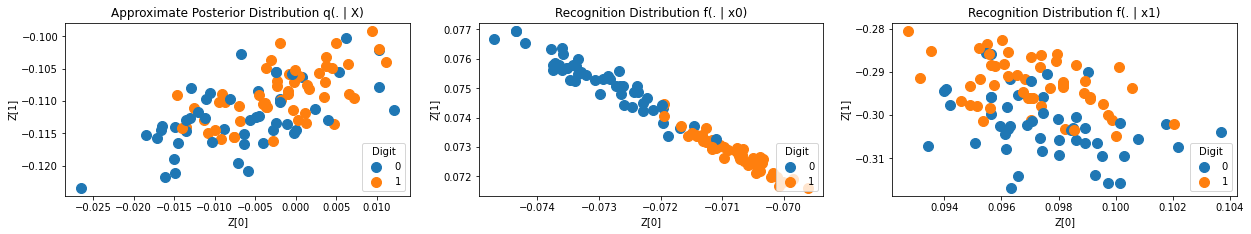

In [390]:
# Forward test data
import utils_process

dim_latent = rpm.dim_latent
heigh = int(dim_latent * (dim_latent - 1) / 2)
width = rpm.num_factors + 1
plt.figure(figsize=(width * 7, heigh * 7))  

for J in range(-1, rpm.num_factors):

    #J = 0
    qdist, fdist = rpm.get_posteriors(obs_test)

    if J == -1:
        mean, vari = qdist.mean_covariance()
        title_str = 'Approximate Posterior Distribution q(. | X)'
    else:
        mean, vari = fdist.mean_covariance()
        mean = mean[J]
        vari = vari[J]
        title_str = 'Recognition Distribution f(. | x' + str(J) + ')'

    mean = mean.detach().clone().cpu().numpy()
    vari = vari.detach().clone().cpu().numpy()


    # Plot testing Data
    subset = 100
    xx = mean[:subset]
    zz = vari[:subset]
    yy = test_labels[:subset, J]
    cmap = plt.get_cmap("tab10")
    
    compt = 0
    for uu in range(dim_latent -1):
        for vv in range(uu+1, dim_latent):
            offset = width * compt 
            compt += 1
            
            ax = plt.subplot(dim_latent, width, J + 2 + offset)
            for ii in range(subset):
                y0 = int(yy[ii].numpy())
                x0 = xx[ii]
                z0 = zz[ii]
                plt.scatter(x0[uu], x0[vv], s=100, color=cmap(y0))
                #utils_process.confidence_ellipse(x0[[uu, vv]], z0[[uu, vv]][:, [uu, vv]], ax, n_std=1.0, facecolor=cmap(y0), alpha=0.1)

            for ii in np.unique(yy):
                y0 = yy[np.where(yy == ii)]
                x0 = xx[np.where(yy == ii)]
                plt.scatter(x0[0, uu], x0[0, vv], s=100, label=str(int(ii)), color=cmap(int(y0[0].numpy())))
                
#            plt.xlim([-2, 2])
#            plt.ylim([-2, 2])
            plt.legend(title = 'Digit', loc= 'lower right')
            plt.xlabel('Z[' + str(uu) + ']')
            plt.ylabel('Z[' + str(vv) + ']')
            plt.title(title_str)

In [391]:
from flexible_multivariate_normal import FlexibleMultivariateNormal

qmean, qvar = qdist.mean_covariance()
fmean, fvar = fdist.mean_covariance()
n1, n2 = [xx.clone().detach() for xx in rpm.forwarded_prior]
pmean, pvar = FlexibleMultivariateNormal(n1, n2, init_cholesky=False, init_natural=True, store_suff_stat_mean=True).mean_covariance()
pmean = pmean.cpu().numpy()
pvar = pvar.cpu().numpy()



In [334]:
print(fvar[:, 0])

tensor([[[ 0.9452,  0.1393],
         [ 0.1393,  0.1626]],

        [[ 0.9255, -0.0352],
         [-0.0352,  0.1170]]], device='cuda:0')


In [331]:
from flexible_multivariate_normal import vector_to_tril

tmp = vector_to_tril(rpm.precision_chol_vec_factors)
gain = torch.matmul(tmp, tmp.transpose(-1, -2))


print(gain)


tensor([[[ 0.1054, -0.5185],
         [-0.5185,  3.0182]],

        [[ 0.0465,  0.1647],
         [ 0.1647,  3.8249]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)
